# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test)

In [6]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-08


In [7]:
wholedata_silver = convert_silver(train_merge)

In [8]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [9]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [10]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [11]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [12]:
date_val = datetime.datetime(2014, 10, 1)

In [13]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_category_id', 'item_category_name','item_cnt_day']].copy()

In [14]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


In [15]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [16]:
train_full = completion_semi_gold(train_window)

In [17]:
train_full.head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order
0,2,30,2-30,40,2013-01-01,0.0,1
1,2,31,2-31,37,2013-01-01,0.0,1
2,2,32,2-32,40,2013-01-01,0.0,1
3,2,33,2-33,37,2013-01-01,1.0,1
4,2,76,2-76,37,2013-01-01,0.0,1


In [18]:
train_full.sort_values('Sale', ascending = False)

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order
658884,31,20949,31-20949,71,2013-12-01,1305.0,12
653297,25,20949,25-20949,71,2013-12-01,1066.0,12
601679,31,20949,31-20949,71,2013-11-01,989.0,11
544474,31,20949,31-20949,71,2013-10-01,978.0,10
487269,31,20949,31-20949,71,2013-09-01,950.0,9
...,...,...,...,...,...,...,...
409882,12,6740,12-6740,30,2013-08-01,-2.0,8
581285,12,3734,12-3734,23,2013-11-01,-2.0,11
409538,12,1829,12-1829,28,2013-08-01,-2.0,8
56799,59,14931,59-14931,69,2013-01-01,-2.0,1


### Exploration of the features

<b> scalling shopitem wise over L 1 differenciation per shopitem

In [19]:
def feature_silver(data):
    data = data.copy()
    ## feature of diff using one lag
    data['SaleL1M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
    data['SaleL2M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(2)
    data['SaleL3M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(3)
    data['SaleL4M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(4)
    data['SaleL11M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(11)
    data['SaleL12M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(12)
    data['SaleL13M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(13)
    
    data_lagdiff = data.assign(L0M_L1M = data.Sale - data.SaleL1M)  ### This is new target ???? but yeaaaaaHHH
    data_lagdiff = data_lagdiff.assign(L1M_L2M = data_lagdiff.SaleL1M - data_lagdiff.SaleL2M) 
    data_lagdiff = data_lagdiff.assign(L2M_L3M = data_lagdiff.SaleL2M - data_lagdiff.SaleL3M)
    data_lagdiff = data_lagdiff.assign(L3M_L4M = data_lagdiff.SaleL3M - data_lagdiff.SaleL4M)
    
    data_lagdiff = data_lagdiff.assign(L1M_L11M = data_lagdiff.SaleL1M - data_lagdiff.SaleL11M)
    data_lagdiff = data_lagdiff.assign(L1M_L12M = data_lagdiff.SaleL1M - data_lagdiff.SaleL12M)
    data_lagdiff = data_lagdiff.assign(L1M_L13M = data_lagdiff.SaleL1M - data_lagdiff.SaleL13M)
    
    data_lagdiff = data_lagdiff.drop(columns = ['SaleL2M','SaleL3M','SaleL3M','SaleL4M', 'SaleL11M', 'SaleL12M', 'SaleL13M'])
    
    ### Categorical price
    data_lagdiff = data_lagdiff.assign(categVolume = np.where( data_lagdiff.SaleL1M > 100, 'A',
                                                np.where( data_lagdiff.SaleL1M > 70, 'B',
                                                np.where( data_lagdiff.SaleL1M > 30, 'C',
                                                np.where( data_lagdiff.SaleL1M > 10, 'D',
                                                np.where( data_lagdiff.SaleL1M > 5, 'F',
                                                np.where( data_lagdiff.SaleL1M >= 3, 'G','H'
                                                         )))))))
    
    ### Categorical completion
    data_lagdiff = data_lagdiff.assign( possCounts = np.where(data_lagdiff.Sale > 0, 1, 0) )
    data_lagdiff['possCounts'] = data_lagdiff.groupby(['shopitem']).possCounts.transform(lambda x: x.sum())
    data_lagdiff = data_lagdiff.assign(categSale = np.where( data_lagdiff.possCounts > 10, 'A',
                                                np.where( data_lagdiff.possCounts > 5, 'B',
                                                np.where( data_lagdiff.possCounts > 3, 'C',
                                                np.where( data_lagdiff.possCounts <= 3, 'D','D'
                                                        )))))
    
    #focussed max shop
    data_lagdiff['maxSection'] = data_lagdiff.groupby(['shop_id','categSale']).Sale.transform('max')
    
    ### furhter lags in function of diff
    data_lagdiff['L11M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(11)
    data_lagdiff['L12M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(12)
    data_lagdiff['L13M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(13)
     
    ## Count zeros
    data_lagdiff['count0'] = np.where(data_lagdiff.SaleL1M == 0,1,0)
    data_lagdiff['Roll0count'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).count0.transform(lambda x: x.rolling(4, 1).sum())
    data_lagdiff = data_lagdiff.drop(columns = ['count0'])
    ## Count no variations
    data_lagdiff['count0'] = np.where(data_lagdiff.L1M_L2M == 0,1,0)
    data_lagdiff['Roll0L1'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).count0.transform(lambda x: x.rolling(4, 1).sum())
    #data_lagdiff['Roll0L1Mean'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).Roll0L1.transform(lambda x: x.rolling(4, 1).mean())
    data_lagdiff = data_lagdiff.drop(columns = ['count0'])
    
    ## addition lags
    data_lagdiff['Roll0L1L6'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0L1'].shift(6)
    data_lagdiff['Roll0L1L12'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0L1'].shift(12)
    data_lagdiff['Roll0countL6'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0count'].shift(6)
    data_lagdiff['Roll0countL12'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0count'].shift(12)
    
    ## month
    data_lagdiff = data_lagdiff.assign(month = data_lagdiff.Date.dt.month)
    
    max_date = data_lagdiff.Date.max() + relativedelta(months=1)
    max_date_month = max_date.month
    data_lagdiff['monthToPredict'] = np.where(data_lagdiff['month'] == max_date_month,1,0)
        
    ## year
    data_lagdiff['Year'] = data_lagdiff.Date.dt.year
    ## quarter
    data_lagdiff['Quarter'] = np.where(data_lagdiff.month.isin([1,2,3]),1,
                            np.where(data_lagdiff.month.isin([4,5,6]),2,
                            np.where(data_lagdiff.month.isin([7,8,9]),3,
                            np.where(data_lagdiff.month.isin([10,11,12]),4,0))))
    

    
    data_lagdiff['maxSaleL1M'] = data_lagdiff.groupby(['shopitem']).SaleL1M.transform('max') ## To drop Later
    
    ####################################
    ### Features for explosion items ###
    ####################################
    data_lagdiff['maxVar'] = data_lagdiff.groupby(['shopitem']).L1M_L2M.transform('max')
    data_lagdiff['minVar'] = data_lagdiff.groupby(['shopitem']).L1M_L2M.transform('min')

    data_lagdiff = data_lagdiff.assign( noVar = np.where(data_lagdiff.L1M_L2M == 0, 1, 0) )
    data_lagdiff['countNoVar'] = data_lagdiff.groupby(['shopitem']).noVar.transform('sum')
    
    data_lagdiff['FlagShop'] = np.where((data_lagdiff.maxVar > 10) & (data_lagdiff.minVar < 2), data_lagdiff.shop_id, 0)
    data_lagdiff['FlagCategory'] = np.where((data_lagdiff.maxVar > 10) & (data_lagdiff.minVar < 2), data_lagdiff.item_category_id, 0)
    
    data_lagdiff = data_lagdiff.assign(possitionMax = np.where( data_lagdiff.L1M_L2M == data_lagdiff.maxVar, data_lagdiff.Order, 0))
    data_lagdiff['pivotx'] = data_lagdiff.groupby(['shopitem']).possitionMax.transform('max')
    data_lagdiff = data_lagdiff.assign(befExplotion = np.where(data_lagdiff.Order < data_lagdiff.pivotx , 1, 0))
    data_lagdiff['SumBefExplotion'] = data_lagdiff.groupby(['shopitem']).befExplotion.transform('sum')
    
    data_lagdiff = data_lagdiff.drop(columns = ['pivotx','possitionMax'])
    
    ## interaction
    data_lagdiff['countNoVar'] = data_lagdiff['noVar'] * data_lagdiff['countNoVar']
    data_lagdiff['FlagShop'] = data_lagdiff['noVar'] * data_lagdiff['FlagShop']
    data_lagdiff['FlagCategory'] = data_lagdiff['noVar'] * data_lagdiff['FlagCategory']
    data_lagdiff['befExplotion'] = data_lagdiff['noVar'] * data_lagdiff['befExplotion']
    data_lagdiff['SumBefExplotion'] = data_lagdiff['noVar'] * data_lagdiff['SumBefExplotion']
    
    ####################################
    ##### end ##########################
    ####################################
    
    ####################################
    ####### maps for feature gen #######
    ####################################
    
    data_lagdiff['maxVar'] = data_lagdiff.groupby(['shopitem']).L0M_L1M.transform('max')
    data_lagdiff['minVar'] = data_lagdiff.groupby(['shopitem']).L0M_L1M.transform('min')
    
    df_feature = data_lagdiff[(data_lagdiff.maxVar > 10) & (data_lagdiff.minVar < 2) ]\
    [['shop_id','item_id','shopitem','item_category_id','Date', 'Sale','Order', 'L0M_L1M','maxVar']].copy()

    df_feature['month'] = df_feature['Date'].dt.month
    df_feature['pivotDiff'] = np.where(df_feature.Sale == 0, 0,1)
    df_feature['reorder1'] = df_feature.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotDiff']).cumcount() + 1
    df_feature['Starter'] = np.where((df_feature.pivotDiff == 1) & (df_feature.reorder1 == 1),df_feature.Order,0)

    df_feature['pivotMax'] = df_feature.groupby(['shopitem']).Starter.transform('max')
    df_feature['OrderBef'] = np.where(df_feature.Order < df_feature.pivotMax, df_feature.Order,0)
    df_feature['pivotSep'] = np.where(df_feature.OrderBef > 0 ,1,0)

    df_feature['reorder'] = df_feature.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotSep']).cumcount() + 1
    df_feature['capture'] = np.where(df_feature.pivotSep == 1, 1,np.where((df_feature.pivotSep == 0) & (df_feature.reorder <= 3),1,0 ) )
    df_feature = df_feature[df_feature.capture == 1]

    feature_item = df_feature[(df_feature.pivotSep == 0) ].groupby(['item_id','reorder']).agg(meanVarExploItem = ('L0M_L1M','median')).reset_index()
    feature_item['reorder'] = feature_item['reorder'] - 1
    feature_shop = df_feature[(df_feature.pivotSep == 0) ].groupby(['shop_id','reorder']).agg(meanVarExploShop = ('L0M_L1M','median')).reset_index()
    feature_shop['reorder'] = feature_shop['reorder'] - 1
    feature_month = df_feature[df_feature.Starter != 0 ].groupby('month').agg(countMonth = ('L0M_L1M', 'count')).reset_index()
    
    features_dictionary = {'Item_feature': feature_item, 'Shop_feature': feature_shop, 'month_feature': feature_month}
    
    ####################################
    ##### end ##########################
    ####################################
    
    
    ###############################################
    ####### maps for feature highVariation #######
    ###############################################
    
    df_feature = data_lagdiff[['shop_id','item_id','shopitem','item_category_id','Date', 'Sale','Order', 'L0M_L1M','minVar','maxVar']].copy()
    df_feature['count0'] = np.where(df_feature.Sale == 0,1,0)
    df_feature['month'] = df_feature['Date'].dt.month
    df_feature['count0'] = df_feature.sort_values('Date').groupby(['shopitem']).count0.transform('sum')
    df_feature['SaleNew'] = np.where(df_feature.Sale == 0,np.nan, df_feature.Sale)
    df_feature['minSale'] = df_feature.sort_values('Date').groupby(['shopitem']).SaleNew.transform('min')
    
    df_feature = df_feature[(abs(df_feature.maxVar) > 3) &(df_feature.count0 < 6)]
    
    def q2(x):
        return x.quantile(0.50)

    def q3(x):
        return x.quantile(0.95)

    df_feature['Year'] = df_feature.Date.dt.year
    df_feature['Quarter'] = np.where(df_feature.month.isin([1,2,3]),1,
                            np.where(df_feature.month.isin([4,5,6]),2,
                            np.where(df_feature.month.isin([7,8,9]),3,
                            np.where(df_feature.month.isin([10,11,12]),4,0))))

    feature_med = df_feature.groupby(['item_id','Order','Year','Quarter','month']).agg(medianVar = ('L0M_L1M',q2),
                                                                 highVar = ('L0M_L1M',q3)).reset_index()
    feature_med['HighMeanQuart'] = feature_med.groupby(['Year','Quarter']).highVar.transform('mean')
    feature_med['medianVarL12'] = feature_med.sort_values('Order').groupby(['item_id'])['medianVar'].shift(12)
    feature_med['HighVarL12'] = feature_med.sort_values('Order').groupby(['item_id'])['highVar'].shift(12)

    feature_var_season = feature_med.groupby(['item_id','Year','Quarter'])[['HighMeanQuart']].max().reset_index()
    feature_var_season['HighMeanQuartL4'] = feature_var_season.sort_values(['Year','Quarter']).groupby(['item_id'])['HighMeanQuart'].shift(4)
    feature_var_season = feature_var_season.fillna(0)
    feature_var_season['SeasonalVariation'] = feature_var_season.HighMeanQuart - feature_var_season.HighMeanQuartL4
    feature_var_season = feature_var_season.drop(columns = 'HighMeanQuart')


    feature_med = feature_med.merge(feature_var_season, on = ['item_id','Year','Quarter'],how = 'left')
    feature_med = feature_med[['item_id','Order','Year','month','medianVarL12','SeasonalVariation','HighVarL12']]
    
    features_dictionary['HighVarSeason'] = feature_med
    ####################################
    ##### end ##########################
    ####################################
    
    data_lagdiff = data_lagdiff.drop(columns = ['maxVar','minVar'])
    data_result = data_lagdiff
    return data_result, features_dictionary

In [20]:
def integration_new_features_map(data, dict_feature):
    
    data_wow = data.copy()
    data_wow['maxVar'] = data_wow.groupby(['shopitem']).L1M_L2M.transform('max')
    data_wow['minVar'] = data_wow.groupby(['shopitem']).L1M_L2M.transform('min')
    
    ##### detector ######
    
    data_wow['labeling'] = np.where((data_wow.maxVar > 10) & (data_wow.minVar < 2),1,0)
    data_wow['labeling'] = data_wow.groupby(['shopitem']).labeling.transform('max')
    data_wow['pivotDiff'] = np.where(data_wow.Sale == 0, 0,1)
    data_wow['reorder'] = data_wow.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotDiff']).cumcount() + 1
    data_wow['reorder'] = data_wow['reorder']*data_wow['pivotDiff']
    data_wow['reorder'] = data_wow.sort_values('Date').groupby(['shopitem'])['reorder'].shift(1)
    
    #### mergin
    
    data_wow = data_wow.merge(features_dictionary['Item_feature'], on = ['item_id','reorder'], how = 'left')
    data_wow = data_wow.merge(features_dictionary['Shop_feature'], on = ['shop_id','reorder'], how = 'left')
    data_wow = data_wow.merge(features_dictionary['month_feature'], on = ['month'], how = 'left')
    data_wow = data_wow.merge(features_dictionary['HighVarSeason'], on = ['item_id','Year','month','Order'], how = 'left')
    
    ### feature correction
    data_wow['meanVarExploItem'] = np.where(data_wow['labeling'] == 1, data_wow['meanVarExploItem'],0 )
    data_wow['meanVarExploShop'] = np.where(data_wow['labeling'] == 1, data_wow['meanVarExploShop'],0 )
    data_wow['countMonth'] = np.where(data_wow['labeling'] == 1, data_wow['countMonth'],0 )
    
    data_wow = data_wow.drop(columns = ['maxVar','minVar','pivotDiff','reorder','Year','Quarter','befExplotion'])
    
    return data_wow

In [21]:
train_feature, features_dictionary = feature_silver(train_full)
train_feature = integration_new_features_map(data = train_feature, dict_feature= features_dictionary) 

In [22]:
df_test = train_feature[(train_feature.item_id == 4382) & (train_feature.shop_id == 42)]
df_test.head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,SaleL1M,L0M_L1M,L1M_L2M,...,FlagShop,FlagCategory,SumBefExplotion,labeling,meanVarExploItem,meanVarExploShop,countMonth,medianVarL12,SeasonalVariation,HighVarL12
36895,42,4382,42-4382,40,2013-01-01,0.0,1,NaN,NaN,NaN,...,0,0,0,0,0.0,0.0,0,NaN,NaN,NaN
94100,42,4382,42-4382,40,2013-02-01,0.0,2,0.0,0.0,NaN,...,0,0,0,0,0.0,0.0,0,NaN,NaN,NaN
151305,42,4382,42-4382,40,2013-03-01,0.0,3,0.0,0.0,0.0,...,0,0,10,0,0.0,0.0,0,NaN,NaN,NaN
208510,42,4382,42-4382,40,2013-04-01,0.0,4,0.0,0.0,0.0,...,0,0,10,0,0.0,0.0,0,NaN,NaN,NaN
265715,42,4382,42-4382,40,2013-05-01,0.0,5,0.0,0.0,0.0,...,0,0,10,0,0.0,0.0,0,NaN,NaN,NaN


In [23]:
train_feature.columns

Index(['shop_id', 'item_id', 'shopitem', 'item_category_id', 'Date', 'Sale',
       'Order', 'SaleL1M', 'L0M_L1M', 'L1M_L2M', 'L2M_L3M', 'L3M_L4M',
       'L1M_L11M', 'L1M_L12M', 'L1M_L13M', 'categVolume', 'possCounts',
       'categSale', 'maxSection', 'L11M', 'L12M', 'L13M', 'Roll0count',
       'Roll0L1', 'Roll0L1L6', 'Roll0L1L12', 'Roll0countL6', 'Roll0countL12',
       'month', 'monthToPredict', 'maxSaleL1M', 'noVar', 'countNoVar',
       'FlagShop', 'FlagCategory', 'SumBefExplotion', 'labeling',
       'meanVarExploItem', 'meanVarExploShop', 'countMonth', 'medianVarL12',
       'SeasonalVariation', 'HighVarL12'],
      dtype='object')

In [24]:
features_dictionary['HighVarSeason'].head()

,item_id,Order,Year,month,medianVarL12,SeasonalVariation,HighVarL12
0,30,1,2013,1,NaN,3.304620,NaN
1,30,2,2013,2,NaN,3.304620,NaN
2,30,3,2013,3,NaN,3.304620,NaN
3,30,4,2013,4,NaN,2.756491,NaN
4,30,5,2013,5,NaN,2.756491,NaN


In [29]:
def features_rows_train_silver(data, features, target ,sample_1 = 0.70, sample_2 = 0.20,validation = None, dates_back = 3):
    data = data.copy()
    if validation:
        data_result = data[ data.Date == validation][features + [target]].fillna(0)
        features_new = list(data_result.columns)
        features_new.remove(target)
        data_result = data_result[features_new + [target]]
        
    else:
        ### splits
        ### conventional for regular time series
    
        cutoff = 3
        
        ### Date cqpture ####################
        date_max = data.Date.max()
        months_to_get = [4,5,6,10,11]
        minyear = 2014
        min_date = date_max - relativedelta(months=dates_back)

        year_i = date_max.year

        dates_result = list()

        while year_i >= minyear:
            for monthi in months_to_get:
                dates_result.append(datetime.datetime(year_i, monthi, 1))
                dates_result = [x for x in dates_result if x <= date_max]
            year_i = year_i - 1

        dates_result = dates_result + [date_max - relativedelta(months=i) for i in range(0,dates_back +1)]
        dates_result = list(set(dates_result))
        dates_result.sort()
        ######################################
    
        data_comp1 = data[ (data.maxSaleL1M > cutoff) & (data.Date.isin(dates_result))][features + [target]].sample(frac = sample_1)
        ### until here we just covered a very little section
        data_comp2 = data[ (data.maxSaleL1M <= cutoff) & (data.Date >= min_date) & (data.Date <= date_max)][features + [target]].sample(frac = sample_2)
        data_comp3 = data[ (data.maxSaleL1M <= cutoff) & (data.Date.isin(dates_result))][features + [target]].sample(frac = sample_2)
        
        ## concat results 
        
        data_result = pd.concat([data_comp1,data_comp2,data_comp3], axis = 0).fillna(0)
        ### Result
        features_new = list(data_result.columns)
        features_new.remove(target)
        data_result = data_result[features_new + [target]]
    
    return data_result

In [30]:
train_feature.columns

Index(['shop_id', 'item_id', 'shopitem', 'item_category_id', 'Date', 'Sale',
       'Order', 'SaleL1M', 'L0M_L1M', 'L1M_L2M', 'L2M_L3M', 'L3M_L4M',
       'L1M_L11M', 'L1M_L12M', 'L1M_L13M', 'categVolume', 'possCounts',
       'categSale', 'maxSection', 'L11M', 'L12M', 'L13M', 'Roll0count',
       'Roll0L1', 'Roll0L1L6', 'Roll0L1L12', 'Roll0countL6', 'Roll0countL12',
       'month', 'monthToPredict', 'maxSaleL1M', 'noVar', 'countNoVar',
       'FlagShop', 'FlagCategory', 'SumBefExplotion', 'labeling',
       'meanVarExploItem', 'meanVarExploShop', 'countMonth', 'medianVarL12',
       'SeasonalVariation', 'HighVarL12'],
      dtype='object')

In [31]:
to_drop_columns = ['Date','Sale','SaleL1M']
numericals = ['L1M_L2M', 'L2M_L3M', 'L3M_L4M','L1M_L11M', 'L1M_L12M', 'L1M_L13M', 'possCounts','maxSection', 'L11M', 'L12M', 'L13M', 'Roll0count',
       'Roll0L1', 'Roll0L1L6', 'Roll0L1L12', 'Roll0countL6', 'Roll0countL12','month', 'maxSaleL1M', 'noVar', 'countNoVar', 'FlagShop','monthToPredict',
       'FlagCategory', 'SumBefExplotion', 'labeling', 'meanVarExploItem','meanVarExploShop', 'countMonth', 'medianVarL12', 'SeasonalVariation','HighVarL12' ]
categoricals = ['categVolume', 'categSale']
my_features = to_drop_columns + numericals + categoricals
my_target = 'L0M_L1M'
len(my_features) - 3

34

In [39]:
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, sample_1 = 0.55, sample_2 = 0.15, dates_back = 2)

In [40]:
train_selection.head()

,Date,Sale,SaleL1M,L1M_L2M,L2M_L3M,L3M_L4M,L1M_L11M,L1M_L12M,L1M_L13M,possCounts,...,labeling,meanVarExploItem,meanVarExploShop,countMonth,medianVarL12,SeasonalVariation,HighVarL12,categVolume,categSale,L0M_L1M
1123060,2014-08-01,0.0,0.0,-2.0,1.0,1.0,-3.0,-1.0,-3.0,11,...,1,11.5,17.0,212,-2.0,-0.257481,3.75,H,A,0.0
961153,2014-05-01,1.0,4.0,1.0,-2.0,3.0,4.0,4.0,4.0,7,...,0,0.0,0.0,0,0.0,0.000000,0.00,G,B,-3.0
1023626,2014-06-01,16.0,6.0,6.0,0.0,0.0,6.0,6.0,6.0,5,...,0,0.0,0.0,0,0.0,0.000000,0.00,F,C,10.0
1020048,2014-06-01,5.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,4,...,0,0.0,0.0,0,0.0,0.000000,0.00,G,C,1.0
1111541,2014-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,0,0.0,0.0,0,0.0,0.000000,0.00,H,D,0.0


In [41]:
train_selection.shape, train_feature.shape

((101750, 38), (1201305, 43))

### continue ...

In [42]:
def scaler(dataset, features, target, scaler=None, drop_columns = []):
    if scaler:
        features = [x for x in features if x not in drop_columns]
        df = dataset[features + [target]]
        df_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
        return dataset_scaled
    
    else:
        features = [x for x in features if x not in drop_columns]
        df  = dataset[features + [target]]
        scaler = MinMaxScaler()
        scaler.fit(df)

        dataset_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns, index = df.index)
        return dataset_scaled, scaler

In [43]:
my_columns_to_drops = ['noVar', 'categSale_A','labeling','categSale_D','categVolume_G','categVolume_F','categVolume_F','categVolume_H','Roll0count','categSale_C','categVolume_C','categVolume_D','FlagShop','maxSaleL1M']
train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
train_dummies = pd.get_dummies(train_selection[categoricals])
train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [44]:
final_features = list(train_dummies.columns) +  numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [45]:
train_scaled.head()

,categVolume_A,categVolume_B,categVolume_C,categVolume_D,categVolume_F,categVolume_G,categVolume_H,categSale_A,categSale_B,categSale_C,...,monthToPredict,FlagCategory,SumBefExplotion,meanVarExploItem,meanVarExploShop,countMonth,medianVarL12,SeasonalVariation,HighVarL12,L0M_L1M
1123060,0,0,0,0,0,0,1,1,0,0,...,0.0,0.0,0.00,0.265993,0.920635,0.456897,0.467153,0.872257,0.093926,0.488550
961153,0,0,0,0,0,1,0,0,1,0,...,0.0,0.0,0.00,0.188552,0.380952,0.000000,0.481752,1.000000,0.085283,0.485278
1023626,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.00,0.188552,0.380952,0.000000,0.481752,1.000000,0.085283,0.499455
1020048,0,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0.00,0.188552,0.380952,0.000000,0.481752,1.000000,0.085283,0.489640
1111541,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.75,0.188552,0.380952,0.000000,0.481752,1.000000,0.085283,0.488550


In [46]:
train_scaled.shape, train_selection.shape

((101750, 39), (101750, 38))

### ML modeling using ADAboost

In [47]:
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [49]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 40, min_samples_split = 5, min_samples_leaf = 5 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=50, learning_rate=0.015, loss='linear')
my_ABM.fit(X_train, Y_train)

Wall time: 1min 5s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=40,
                                                       max_features=25,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5),
                  learning_rate=0.015)

<b> hold out validation

In [50]:
full_valandtrain = preparing_to_predict(val_data = val_window, train_data = train_window)
full_valandtrain = completion_semi_gold(full_valandtrain)

In [51]:
valandtrain_feature , _ = feature_silver(full_valandtrain)
valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature= features_dictionary) 

In [52]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1, validation = date_val) 

In [53]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
val_dummies = pd.get_dummies(val_selection[categoricals])
val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)

In [54]:
X_val = val_scaled_full[final_features]

In [55]:
Y_pred = my_ABM.predict(X_val)

In [56]:
predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)

In [57]:
my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)

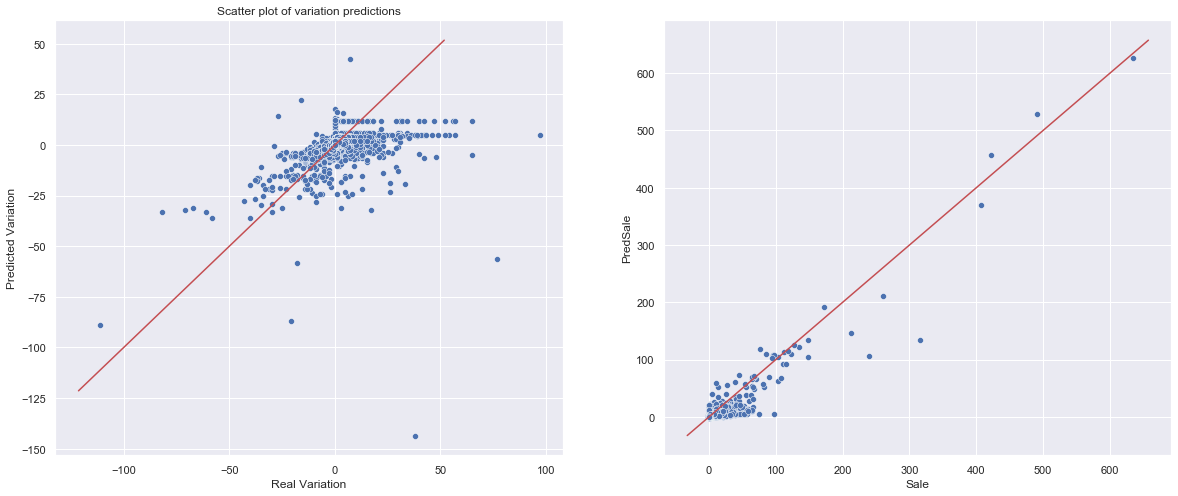

In [58]:
plot_prediction(my_lm_plot)

[Text(0.5, 1.0, 'feature importance')]

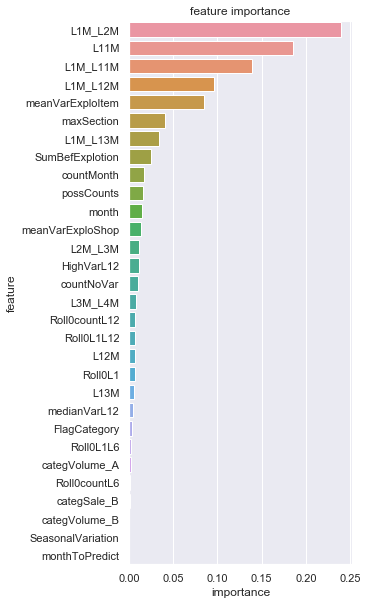

In [59]:
dfplot = pd.DataFrame({'feature':final_features,'importance': list(my_ABM.feature_importances_)}).sort_values('importance',ascending = False)

fig = plt.figure(figsize=(4,10))
ax = sns.barplot(x="importance", y="feature", data=dfplot)
ax.set(title='feature importance')

In [48]:
# drops: 'noVar', 'categSale_A','labeling','categSale_D','categVolume_G','categVolume_F','categVolume_F','categVolume_H','Roll0count','categSale_C','categVolume_C','categVolume_D','FlagShop'

### Production of folds for cross validation

In [61]:
for date_val in test_dates:
    date_val_str = date_val.strftime('%Y-%m-%d')
    train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
    val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_category_id', 'item_category_name','item_cnt_day']].copy()
    train_full = completion_semi_gold(train_window)
    
    train_feature, features_dictionary = feature_silver(train_full)
    train_feature = integration_new_features_map(data = train_feature, dict_feature= features_dictionary) 
    train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, sample_1 = 0.55, sample_2 = 0.15, dates_back = 2)
    
    full_valandtrain = preparing_to_predict(val_data = val_window, train_data = train_window)
    full_valandtrain = completion_semi_gold(full_valandtrain)
    valandtrain_feature , _ = feature_silver(full_valandtrain)
    valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature= features_dictionary) 
    val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1, validation = date_val) 
    
    ### Saving DataFrames
    outdir = f'./generated_datasets/data_{date_val_str}/'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    train_name = os.path.join(outdir, 'train_selection.csv') 
    train_selection.to_csv(path_or_buf = train_name,header=True, index=False)
    
    val_name = os.path.join(outdir, 'val_selection.csv') 
    val_selection.to_csv(path_or_buf = val_name,header=True, index=False)
    
    print(f'the datasets for the date {date_val_str}')

the datasets for the date 2014-11-01
the datasets for the date 2015-04-01
the datasets for the date 2015-05-01
the datasets for the date 2015-06-01
the datasets for the date 2015-07-01
the datasets for the date 2015-08-01
the datasets for the date 2015-09-01
the datasets for the date 2015-10-01


In [62]:
def My_ML_prediction_on_test(dates_vector, model, frac = 0.80):

    data_result = list()

    for datex in dates_vector:
        datex_str = datex.strftime('%Y-%m-%d')
        #### reading files
        train_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/train_selection.csv')
        val_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/val_selection.csv')
        
        train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
        train_dummies = pd.get_dummies(train_selection[categoricals])
        train_scaled = pd.concat([train_dummies,train_scaled],axis = 1).sample(frac = frac)

        ### ML train
        X_train = train_scaled[final_features]
        Y_train = train_scaled[my_target]
        model.fit(X_train, Y_train)
        
        ### Test data prepa
        val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
        val_dummies = pd.get_dummies(val_selection[categoricals])
        val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
        
        X_val = val_scaled_full[final_features]
        
        ## Prediction
        Y_pred = model.predict(X_val)
        
        ## Saving Result
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)
        data_result.append(my_lm_plot)
        #print(f'the prediction over the {datex} data is done')
        
    return pd.concat(data_result)

In [63]:
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 40, min_samples_split = 5, min_samples_leaf = 5 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=50, learning_rate=0.015, loss='linear')
my_test_results = My_ML_prediction_on_test( dates_vector = test_dates, model = my_ABM)

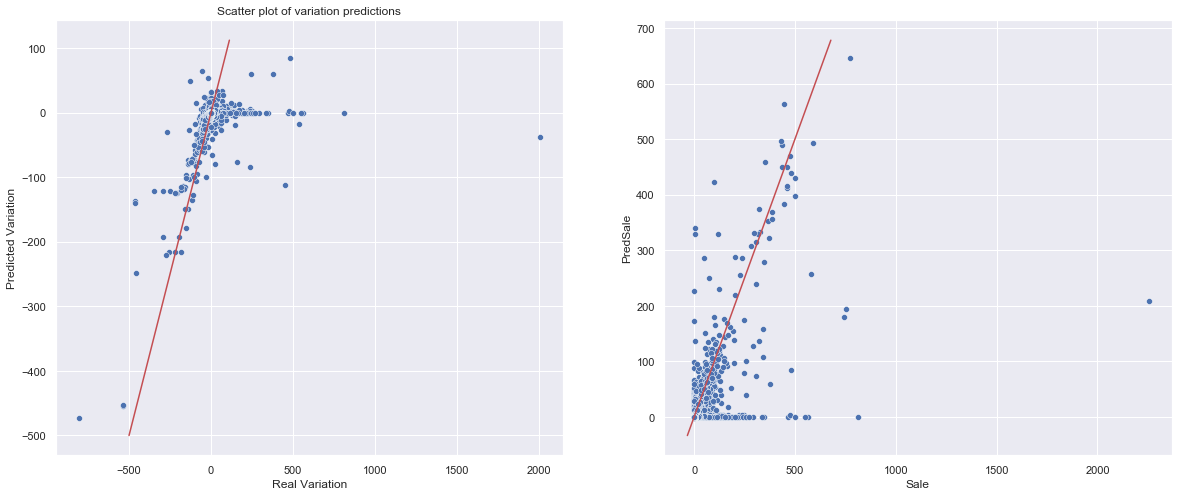

In [64]:
plot_prediction(my_test_results)

In [65]:
rmse_results = plot_metrics(my_test_results)

In [66]:
rmse_results.RMSE.mean()

3.662856938520077

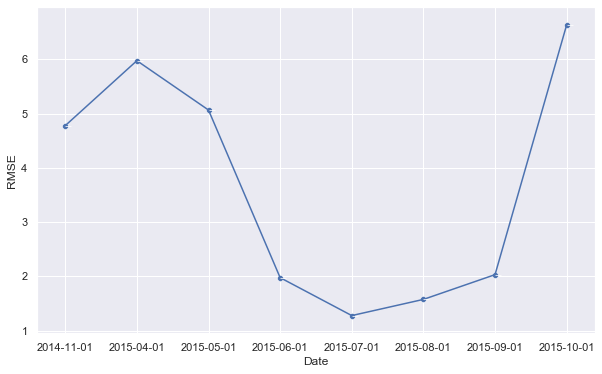

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,6), sharex=True)
ax = sns.lineplot(ax = axs , data = rmse_results, x="Date", y="RMSE", marker = True, )
ax = sns.scatterplot(ax = axs , data = rmse_results, x="Date", y="RMSE", s = 35 )

<b> checking errors

In [68]:
my_test_results_melt = my_test_results.assign(Class = np.where( my_test_results.Sale > 10, 'A',
                                                      np.where( my_test_results.Sale > 7, 'B',
                                                      np.where( my_test_results.Sale > 5, 'C',
                                                      np.where( my_test_results.Sale > 3, 'D','E')))))\
                            .assign(ABSerror = abs(my_test_results.Sale - my_test_results.PredSale))

In [69]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 75) )

ABSerror                                        
Class               A         B         C         D         E
Date                                                         
2014-11-01  26.163405  5.852941  4.125000  3.000000  0.714286
2015-04-01  26.000000  9.000000  6.000000  4.000000  0.571429
2015-05-01  33.500000  8.000000  6.000000  4.000000  0.611823
2015-06-01  21.000000  8.000000  6.000000  4.000000  0.598837
2015-07-01  12.978933  7.000000  5.162500  3.500000  0.444444
2015-08-01  14.714286  7.343750  5.166667  3.573034  0.426966
2015-09-01  20.142857  7.351648  4.833333  3.222222  0.428571
2015-10-01  19.000000  8.714286  6.000000  4.000000  0.584391

In [70]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 100) )

ABSerror                                               
Class                 A          B           C           D           E
Date                                                                  
2014-11-01   557.400000  35.285714   45.400000   38.375000   49.400000
2015-04-01   813.000000  54.750000   16.571429   15.000000   39.400000
2015-05-01   562.125000  48.800000  130.142857  335.400000  327.000000
2015-06-01   209.714286  53.714286   40.600000   29.800000   52.666667
2015-07-01   106.500000  18.000000   13.833333   18.000000   25.750000
2015-08-01   174.600000  34.500000    9.000000   29.000000   31.800000
2015-09-01   167.333333  29.000000   16.333333   34.500000   52.142857
2015-10-01  2044.400000  36.166667   27.444444   30.714286   59.000000

some improvement :/
improve algo speed

### Basic K flod with Parameter tunning

In [72]:
my_adab_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [25,30, 40, 55, 30, 25, 19, 34, 50, 35],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 30, 25, 25, 30, 27, 30, 22, 25, 26],
              
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60],
    'learning_rate' : [0.05, 0.12, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = max_depth_param, min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param , max_features = max_features_param)
    my_adab = AdaBoostRegressor(base_estimator = my_base, n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='linear')
    my_adab_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [111]:
def my_kfold_crossval_and_Hptunning(models_toTrain,frac = 1.0):

    results = {'machine label': list(),
        'machine result': list()}

    for machine,i in zip(models_toTrain, range(1,len(models_toTrain) + 1)):
        label = f'machine-{i}'
        results['machine label'].append(label)
        df_result = My_ML_prediction_on_test( dates_vector = test_dates, model = machine, frac = frac)
        results['machine result'].append(df_result)
        print(label + ' is done')
        
    return results

In [74]:
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  my_adab_models, frac = 0.5)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [81]:
def consolidated_plot_metrics(data):
    list_dfplot = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        df_plot = plot_metrics(result_detail)
        df_plot['machine'] = label
        list_dfplot.append(df_plot)
    
    return pd.concat(list_dfplot)

In [82]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

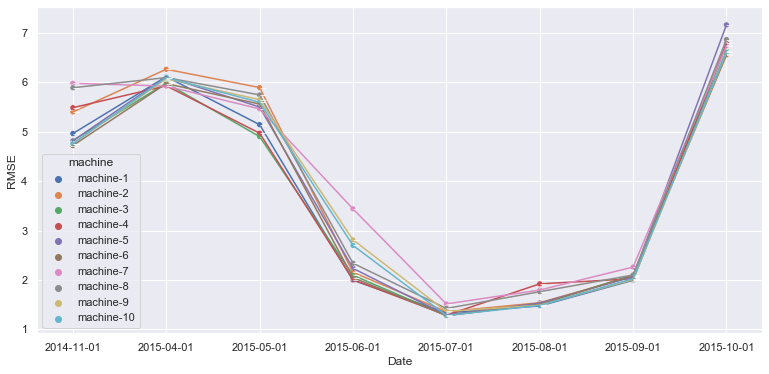

In [85]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [103]:
def consolidated_metrics_MSE(data):
    labels = list()
    RMSEs = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        pred = result_detail['Sale']
        real = result_detail['PredSale']
        rmse = mean_squared_error(real,pred)**(1/2)
        labels.append(label)
        RMSEs.append(rmse)
    
    return pd.DataFrame({'machine':labels,'RMSE': RMSEs}).sort_values('RMSE')

In [104]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
2,machine-3,4.152451
5,machine-6,4.218822
0,machine-1,4.240039
3,machine-4,4.273596
9,machine-10,4.297549
8,machine-9,4.313410
4,machine-5,4.393479
1,machine-2,4.396437
7,machine-8,4.498563
6,machine-7,4.517151


The winer is machine 3

### Winner Prediction

In [115]:
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  [my_adab_models[2]], frac = 1.0)

machine-1 is done


In [116]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

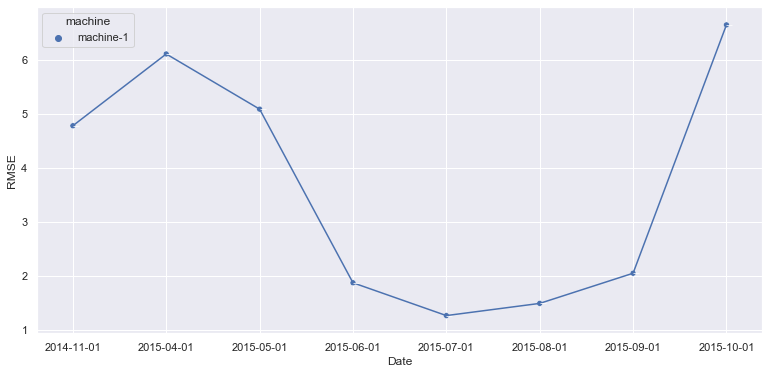

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

### Saving prediction for stacking

In [121]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_adaboost.csv',header = True, index = False)